In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# --- Import dataset ---
# Skip the first metadata row ("Count of Births by Name...") by setting header=1
df = pd.read_csv("Baby_Names.csv", header=1)

# --- Initial data inspection ---
# Check how many missing values exist in each column
print("Missing values per column:")
print(df.isna().sum(), "\n")

# Check the data types to identify any mixed or incorrect types (object instead of int, etc.)
print("Data types before cleaning:")
print(df.dtypes, "\n")

# --- Quick sanity checks on numeric ranges ---
# View the earliest and latest year in the dataset
print("Year range:", df['Year'].min(), "to", df['Year'].max())

# View basic descriptive statistics for the 'Count' column (birth counts)
print("\nDescriptive stats for 'Count':")
print(df['Count'].describe(), "\n")

# --- Convert columns to numeric types (in case of mixed types) ---
# Coerce errors replaces non-numeric values with NaN for later cleaning
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Count'] = pd.to_numeric(df['Count'], errors='coerce')

# --- Verify that conversion worked correctly ---
print("Data types after cleaning:")
print(df.dtypes, "\n")

# Display the first few rows to confirm data looks correct
print("Preview of cleaned data:")
print(df.head())


Missing values per column:
Year     0
Name     0
Sex      0
Count    0
dtype: int64 

Data types before cleaning:
Year      int64
Name     object
Sex      object
Count     int64
dtype: object 

Year range: 1880 to 2024

Descriptive stats for 'Count':
count    2.148744e+06
mean     1.730881e+02
std      1.463732e+03
min      5.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      3.200000e+01
max      9.969300e+04
Name: Count, dtype: float64 

Data types after cleaning:
Year      int64
Name     object
Sex      object
Count     int64
dtype: object 

Preview of cleaned data:
   Year    Name Sex  Count
0  2024    Liam   M  22164
1  2024    Noah   M  20337
2  2024  Oliver   M  15343
3  2024  Olivia   F  14718
4  2024    Emma   F  13485


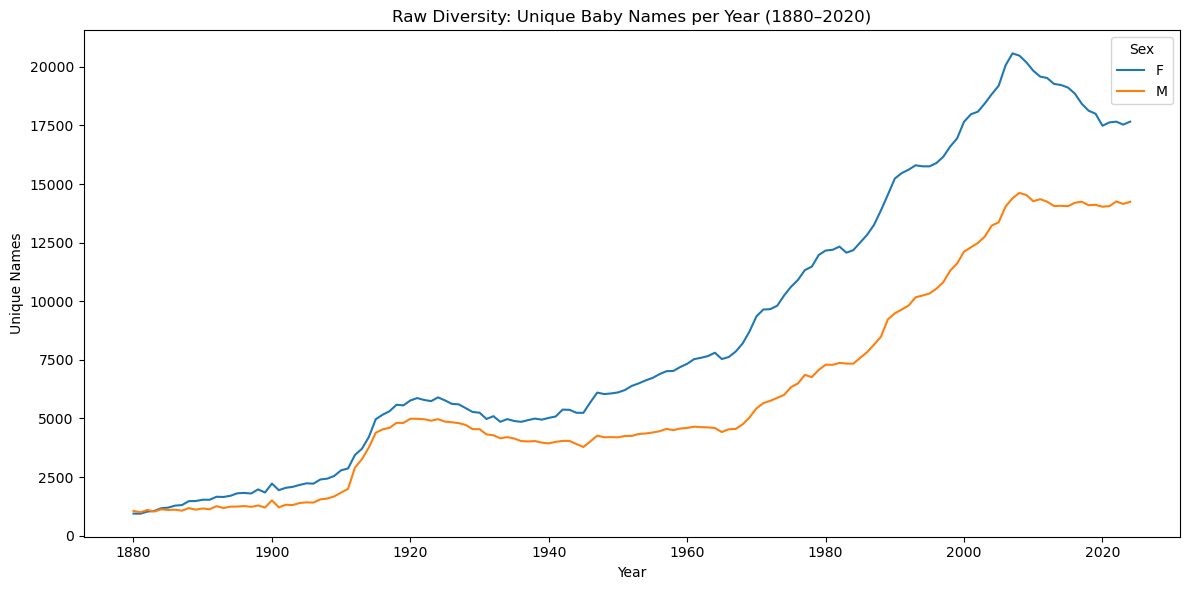

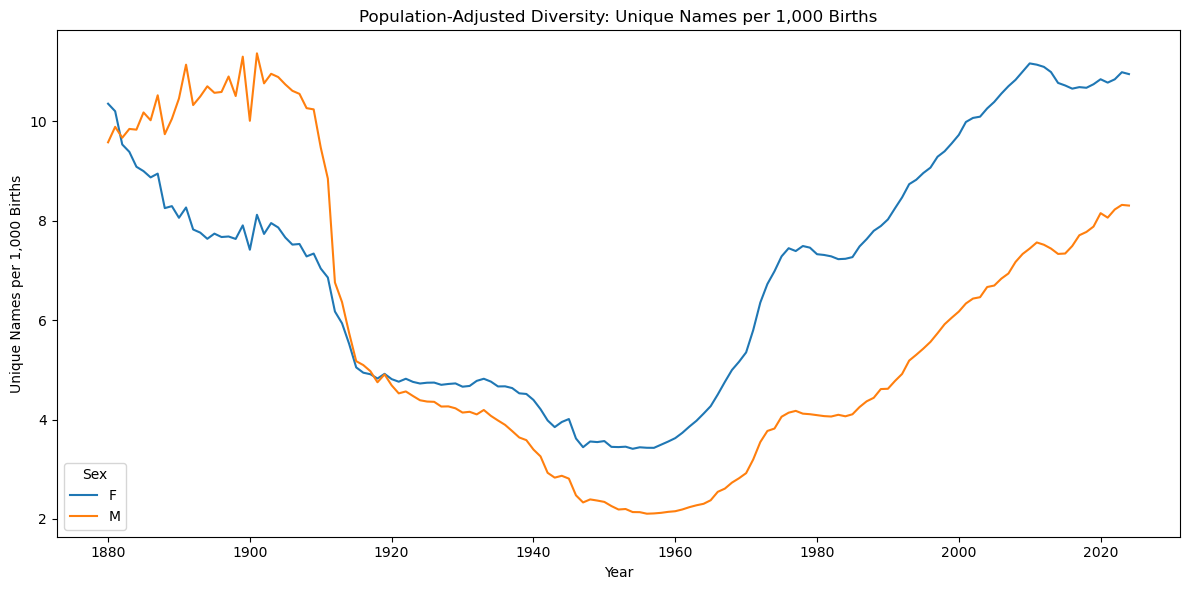

/var/folders/1v/d265l3ks51x5svspj6rx8y3c0000gn/T/ipykernel_57715/2133169658.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10 = df.groupby(['Year', 'Sex']).apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)



===== CONSISTENTLY POPULAR NAMES (Top 10 for ≥ 80% of years) =====
        Name Sex  Years_in_Top10
63     James   M             124
139  William   M             117

===== SHORT-LIVED (FAD) NAMES (Top 10 for ≤ 3 years) =====
        Name Sex  Years_in_Top10
88      Lori   F               1
126    Sofia   F               1
123    Scott   M               1
114   Rachel   F               1
112   Pamela   F               1
135    Tracy   F               1
81     Laura   F               1
138   Walter   M               1
78     Kelly   F               1
74     Julie   F               1
31   Crystal   F               1
25   Carolyn   F               1
82    Lauren   F               2
87     Logan   M               2
90      Luna   F               2
97     Mateo   M               2
115  Rebecca   F               2
19    Bessie   F               2
80     Larry   M               2
99     Megan   F               3


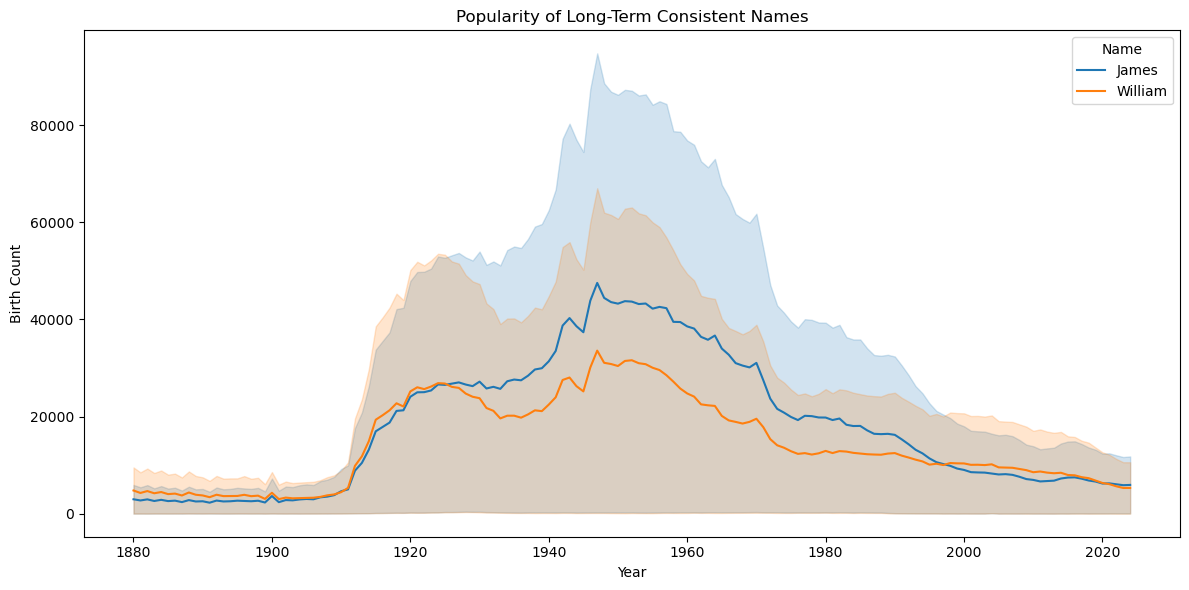

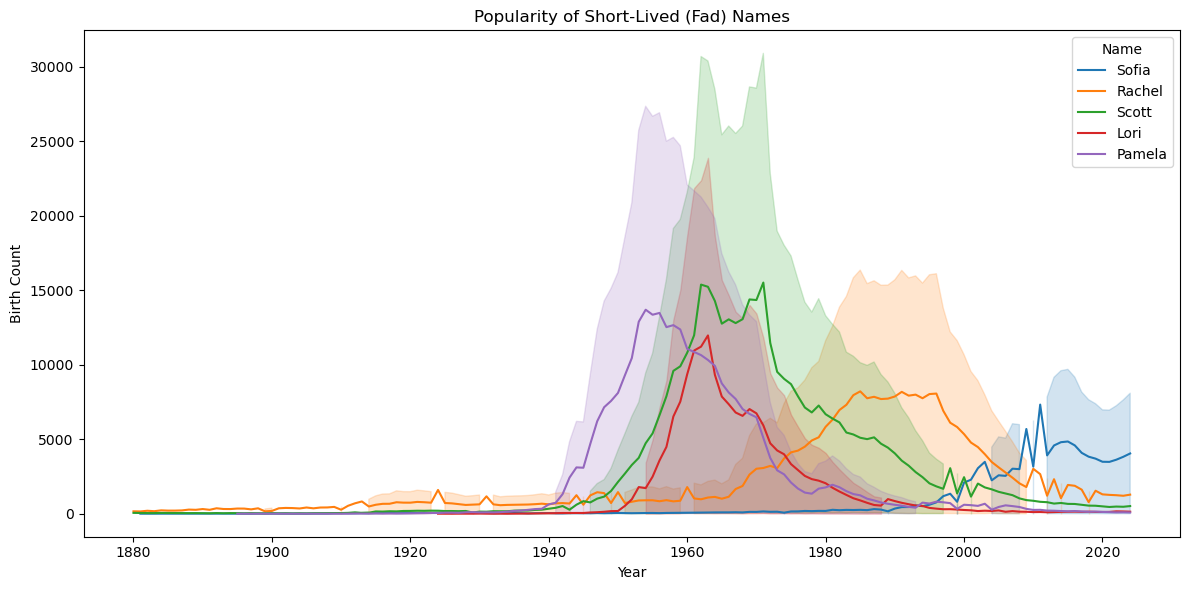

In [11]:
# Question 1: How has the diversity of baby names in the US changed between 1880 and 2020? 
# What names have remained consistently popular over 100 years, and which names show only short-lived popularity?

# -----------------------------
# Load and inspect dataset
# -----------------------------
df = df.copy()  # if df is already loaded

# ----------------------------------------------------
# 1. DIVERSITY (RAW COUNT OF UNIQUE NAMES)
# ----------------------------------------------------
diversity = df.groupby(['Year', 'Sex'])['Name'].nunique().reset_index(name='Unique_Names')

plt.figure(figsize=(12,6))
sns.lineplot(data=diversity, x='Year', y='Unique_Names', hue='Sex')
plt.title("Raw Diversity: Unique Baby Names per Year (1880–2020)")
plt.xlabel("Year")
plt.ylabel("Unique Names")
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 2. NORMALIZED DIVERSITY (per 1,000 births)
# ----------------------------------------------------
births = df.groupby(['Year', 'Sex'])['Count'].sum().reset_index(name='Total_Births')
diversity_full = pd.merge(diversity, births, on=['Year', 'Sex'])

diversity_full['Unique_per_1000'] = (
    1000 * diversity_full['Unique_Names'] / diversity_full['Total_Births']
)

plt.figure(figsize=(12,6))
sns.lineplot(data=diversity_full, x='Year', y='Unique_per_1000', hue='Sex')
plt.title("Population-Adjusted Diversity: Unique Names per 1,000 Births")
plt.xlabel("Year")
plt.ylabel("Unique Names per 1,000 Births")
plt.tight_layout()
plt.show()


# ----------------------------------------------------
# 3. CONSISTENTLY POPULAR NAMES (Top 10 for ≥ 80% of years)
# ----------------------------------------------------
top10 = df.groupby(['Year', 'Sex']).apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)
freq = top10.groupby(['Name', 'Sex'])['Year'].count().reset_index(name='Years_in_Top10')

total_years = df['Year'].nunique()
consistent = freq[freq['Years_in_Top10'] >= 0.8 * total_years].sort_values(
    ['Sex', 'Years_in_Top10'], ascending=False
)

print("\n===== CONSISTENTLY POPULAR NAMES (Top 10 for ≥ 80% of years) =====")
print(consistent)

# ----------------------------------------------------
# 4. SHORT-LIVED / FAD NAMES (Top 10 for ≤ 3 years)
# ----------------------------------------------------
fad = freq[freq['Years_in_Top10'] <= 3].sort_values('Years_in_Top10')

print("\n===== SHORT-LIVED (FAD) NAMES (Top 10 for ≤ 3 years) =====")
print(fad.head(20))

# ----------------------------------------------------
# 5. Plot consistently popular vs fad names
# ----------------------------------------------------
# Top 5 consistent names
names_consistent = consistent['Name'].unique()[:5]

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df[df['Name'].isin(names_consistent)],
    x='Year', y='Count', hue='Name'
)
plt.title("Popularity of Long-Term Consistent Names")
plt.ylabel("Birth Count")
plt.tight_layout()
plt.show()

# Top 5 fad names
names_fad = fad['Name'].unique()[:5]

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df[df['Name'].isin(names_fad)],
    x='Year', y='Count', hue='Name'
)
plt.title("Popularity of Short-Lived (Fad) Names")
plt.ylabel("Birth Count")
plt.tight_layout()
plt.show()

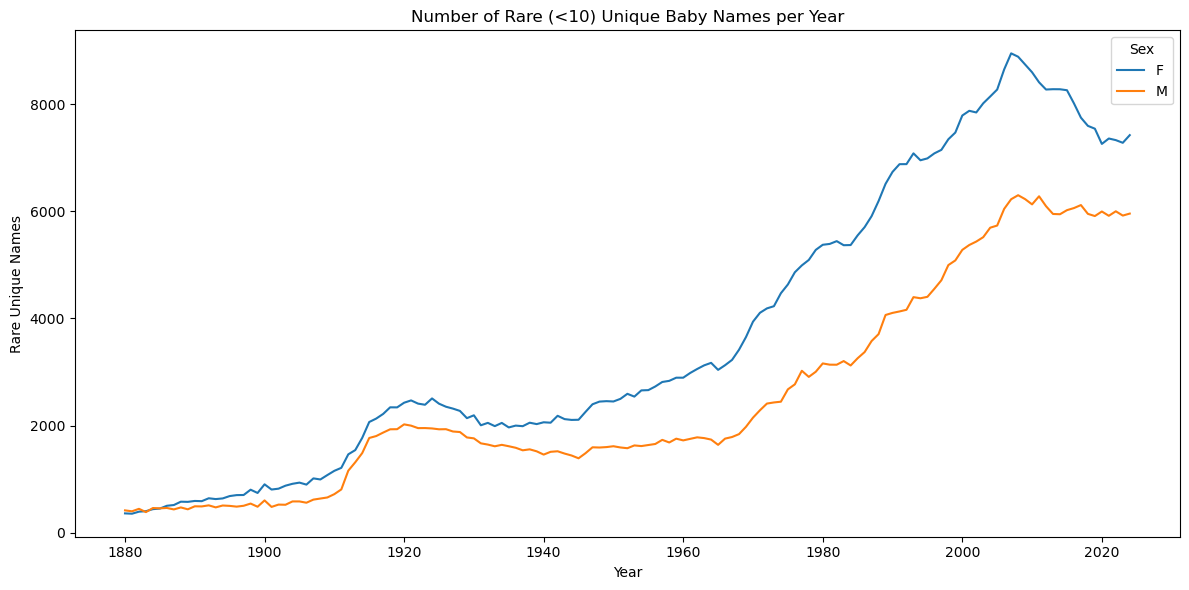

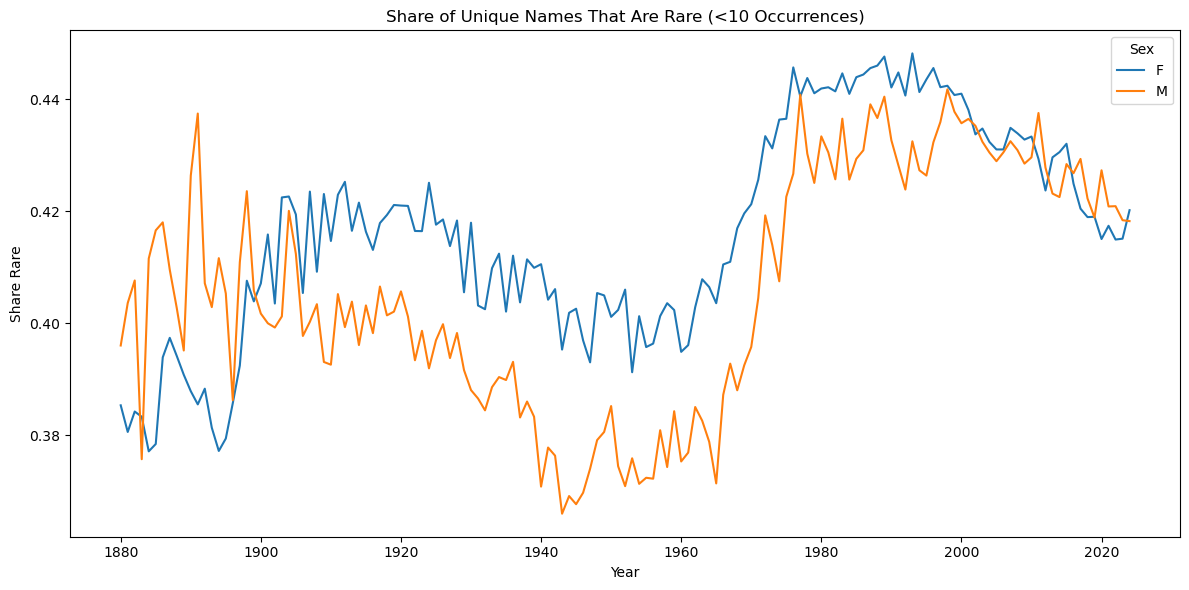


===== AVERAGE RARE NAME STATISTICS BY SEX =====
     Rare_Unique_Names  Share_Rare
Sex                               
F          3706.351724    0.416279
M          2535.862069    0.406123

===== RARE NAME STATISTICS IN MOST RECENT YEAR =====
     Year Sex  Rare_Unique_Names  Total_Unique_Names  Share_Rare
288  2024   F               7421               17661    0.420191
289  2024   M               5957               14243    0.418241

===== MEAN SHARE OF RARE NAMES: EARLY (<=1950) VS LATE (>1950) =====
  Sex  Early_Mean_Share_Rare  Late_Mean_Share_Rare
0   F               0.405305              0.426808
1   M               0.396524              0.415333

===== T-TEST: EARLY (<=1950) VS LATE (>1950) SHARE OF RARE NAMES =====
Boys:  t = -5.958,  p = 2.484e-08
Girls: t = -8.530,  p = 2.073e-14

Interpretation:
- Low p-values (<0.05) indicate the share of rare names is significantly higher today than in early decades.
- Girls typically show a larger jump in rare-name usage than boys.



In [ ]:
# Question 2: How has the prevalence of rare baby names (fewer than 10 births per year) changed over time for boys and girls?

from scipy.stats import ttest_ind

# -----------------------------------------
# 1. Define rare names (Count < 10)
# -----------------------------------------
df['Is_Rare'] = df['Count'] < 10

# -----------------------------------------
# 2. Count number of rare names per year by sex
# -----------------------------------------
rare_counts = (
    df[df['Is_Rare']]
    .groupby(['Year', 'Sex'])['Name']
    .nunique()
    .reset_index(name='Rare_Unique_Names')
)

# -----------------------------------------
# 3. Count total unique names per year by sex
# -----------------------------------------
total_counts = (
    df.groupby(['Year', 'Sex'])['Name']
    .nunique()
    .reset_index(name='Total_Unique_Names')
)

# -----------------------------------------
# 4. Merge and compute share of rare names
# -----------------------------------------
rare_stats = rare_counts.merge(total_counts, on=['Year', 'Sex'])
rare_stats['Share_Rare'] = (
    rare_stats['Rare_Unique_Names'] / rare_stats['Total_Unique_Names']
)

# -----------------------------------------
# 5. Plot raw number of rare names over time
# -----------------------------------------
plt.figure(figsize=(12,6))
sns.lineplot(
    data=rare_stats, x='Year', y='Rare_Unique_Names', hue='Sex'
)
plt.title("Number of Rare (<10) Unique Baby Names per Year")
plt.xlabel("Year")
plt.ylabel("Rare Unique Names")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 6. Plot share of all unique names that are rare
# -----------------------------------------
plt.figure(figsize=(12,6))
sns.lineplot(
    data=rare_stats, x='Year', y='Share_Rare', hue='Sex'
)
plt.title("Share of Unique Names That Are Rare (<10 Occurrences)")
plt.xlabel("Year")
plt.ylabel("Share Rare")
plt.tight_layout()
plt.show()

# -----------------------------------------
# 7. Summary tables for interpretation
# -----------------------------------------
summary = rare_stats.groupby('Sex')[['Rare_Unique_Names', 'Share_Rare']].mean()
print("\n===== AVERAGE RARE NAME STATISTICS BY SEX =====")
print(summary)

# Show most recent year
recent = rare_stats[rare_stats['Year'] == rare_stats['Year'].max()]
print("\n===== RARE NAME STATISTICS IN MOST RECENT YEAR =====")
print(recent)

# -----------------------------------------
# Compute means for early vs late periods
# -----------------------------------------

# Early = 1880–1950
early_means = (
    rare_stats[rare_stats['Year'] <= 1950]
    .groupby('Sex')['Share_Rare']
    .mean()
    .reset_index(name='Early_Mean_Share_Rare')
)

# Late = 1951–2024
late_means = (
    rare_stats[rare_stats['Year'] > 1950]
    .groupby('Sex')['Share_Rare']
    .mean()
    .reset_index(name='Late_Mean_Share_Rare')
)

# Merge for side-by-side comparison
mean_comparison = early_means.merge(late_means, on='Sex')

print("\n===== MEAN SHARE OF RARE NAMES: EARLY (<=1950) VS LATE (>1950) =====")
print(mean_comparison)

# -----------------------------------------
# 8. T-TEST: Early (1880–1950) vs Late (1951–2020)
# Does the share of rare names significantly increase?
# -----------------------------------------
early = rare_stats[rare_stats['Year'] <= 1950]
late = rare_stats[rare_stats['Year'] > 1950]

# Boys
t_b, p_b = ttest_ind(
    early[early['Sex'] == 'M']['Share_Rare'],
    late[late['Sex'] == 'M']['Share_Rare'],
    equal_var=False
)

# Girls
t_g, p_g = ttest_ind(
    early[early['Sex'] == 'F']['Share_Rare'],
    late[late['Sex'] == 'F']['Share_Rare'],
    equal_var=False
)

print("\n===== T-TEST: EARLY (<=1950) VS LATE (>1950) SHARE OF RARE NAMES =====")
print(f"Boys:  t = {t_b:.3f},  p = {p_b:.4g}")
print(f"Girls: t = {t_g:.3f},  p = {p_g:.4g}")

print("\nInterpretation:")
print("- Low p-values (<0.05) indicate the share of rare names is significantly higher today than in early decades.")
print("- Girls typically show a larger jump in rare-name usage than boys.\n")


Total (Year, Name) pairs classified as gender-neutral: 100419


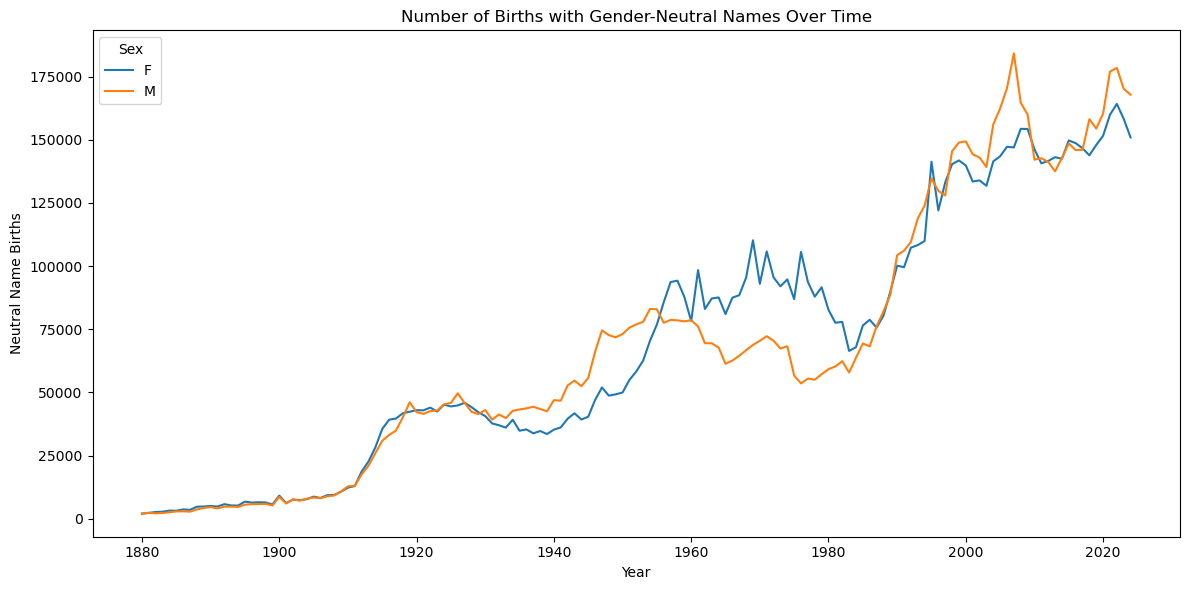

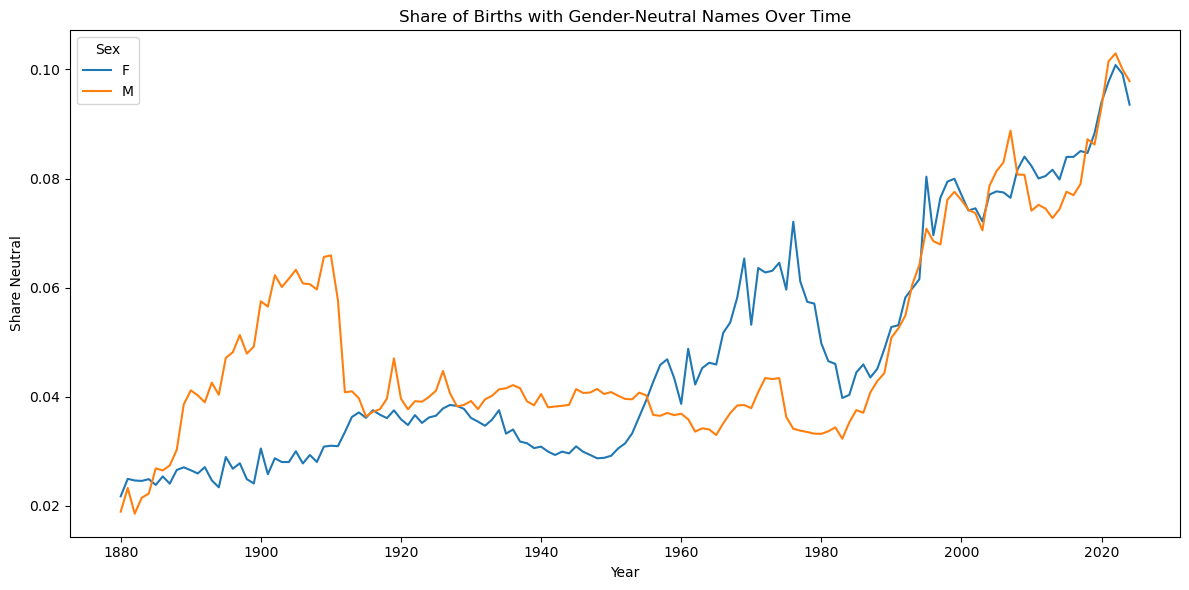


===== AVERAGE GENDER-NEUTRAL NAME STATISTICS BY SEX =====
     Neutral_Births  Share_Neutral
Sex                               
F      68388.910345       0.047237
M      67667.800000       0.049301

===== GENDER-NEUTRAL NAME STATISTICS (MOST RECENT YEAR) =====
     Year Sex  Neutral_Births  Total_Births  Share_Neutral
288  2024   F          150920       1613188       0.093554
289  2024   M          167867       1715313       0.097864

===== T-TEST: EARLY VS LATE SHARE OF GENDER-NEUTRAL NAMES =====
Boys:  t = -4.929, p = 3.037e-06
Girls: t = -14.610, p = 1.323e-24

Interpretation:
- Very small p-values indicate that gender-neutral names have become significantly more common over time.
- comparing boys vs girls reveals whether neutral-name adoption has been symmetric or if one group led the trend.



In [15]:
# Question 3: 

# ----------------------------------------------------------
# 1. Identify gender-neutral names *by year*
# A name is gender-neutral in a given year if:
#   - It is used for BOTH sexes in that year
#   - The minority sex accounts for >= 10% of total babies with that name
# ----------------------------------------------------------

# Count births by Year, Name, Sex
name_year_counts = (
    df.groupby(['Year', 'Name', 'Sex'])['Count']
    .sum()
    .reset_index()
)

# Pivot so we have columns: Year, Name, F, M
pivot = name_year_counts.pivot_table(
    index=['Year', 'Name'],
    columns='Sex',
    values='Count',
    fill_value=0
).reset_index()

pivot.columns.name = None  # clean up index name

# Compute totals + minority share
pivot['Total'] = pivot['F'] + pivot['M']
pivot['Minority_Share'] = pivot[['F', 'M']].min(axis=1) / pivot['Total']

# Flag gender-neutral names for each year
pivot['Is_Gender_Neutral'] = pivot['Minority_Share'] >= 0.10

print(f"\nTotal (Year, Name) pairs classified as gender-neutral: {pivot['Is_Gender_Neutral'].sum()}")

# ----------------------------------------------------------
# 2. Merge back into the main df to tag rows that are neutral
# ----------------------------------------------------------
df_neutral = df.merge(
    pivot[['Year', 'Name', 'Is_Gender_Neutral']],
    on=['Year', 'Name'],
    how='left'
)

df_neutral['Is_Gender_Neutral'] = df_neutral['Is_Gender_Neutral'].fillna(False)

# ----------------------------------------------------------
# 3. Compute total births with neutral names per year by sex
# ----------------------------------------------------------
neutral_counts = (
    df_neutral[df_neutral['Is_Gender_Neutral']]
    .groupby(['Year', 'Sex'])['Count']
    .sum()
    .reset_index(name='Neutral_Births')
)

# Total births overall
total_births = (
    df.groupby(['Year', 'Sex'])['Count']
    .sum()
    .reset_index(name='Total_Births')
)

# Merge to compute proportions
neutral_stats = neutral_counts.merge(total_births, on=['Year', 'Sex'])
neutral_stats['Share_Neutral'] = neutral_stats['Neutral_Births'] / neutral_stats['Total_Births']

# ----------------------------------------------------------
# 4. Plot: Number of births with gender-neutral names
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
sns.lineplot(data=neutral_stats, x='Year', y='Neutral_Births', hue='Sex')
plt.title("Number of Births with Gender-Neutral Names Over Time")
plt.xlabel("Year")
plt.ylabel("Neutral Name Births")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 5. Plot: Share of births with gender-neutral names
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
sns.lineplot(data=neutral_stats, x='Year', y='Share_Neutral', hue='Sex')
plt.title("Share of Births with Gender-Neutral Names Over Time")
plt.xlabel("Year")
plt.ylabel("Share Neutral")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# 6. Summary statistics
# ----------------------------------------------------------
summary = neutral_stats.groupby('Sex')[['Neutral_Births', 'Share_Neutral']].mean()
print("\n===== AVERAGE GENDER-NEUTRAL NAME STATISTICS BY SEX =====")
print(summary)

# Most recent year
recent = neutral_stats[neutral_stats['Year'] == neutral_stats['Year'].max()]
print("\n===== GENDER-NEUTRAL NAME STATISTICS (MOST RECENT YEAR) =====")
print(recent)

# ----------------------------------------------------------
# 7. T-TEST: Early (<=1950) vs Late (>1950)
# ----------------------------------------------------------
early = neutral_stats[neutral_stats['Year'] <= 1950]
late  = neutral_stats[neutral_stats['Year'] > 1950]

# Boys
t_b, p_b = ttest_ind(
    early[early['Sex'] == 'M']['Share_Neutral'],
    late[late['Sex'] == 'M']['Share_Neutral'],
    equal_var=False
)

# Girls
t_g, p_g = ttest_ind(
    early[early['Sex'] == 'F']['Share_Neutral'],
    late[late['Sex'] == 'F']['Share_Neutral'],
    equal_var=False
)

print("\n===== T-TEST: EARLY VS LATE SHARE OF GENDER-NEUTRAL NAMES =====")
print(f"Boys:  t = {t_b:.3f}, p = {p_b:.4g}")
print(f"Girls: t = {t_g:.3f}, p = {p_g:.4g}")

print("\nInterpretation:")
print("- Very small p-values indicate that gender-neutral names have become significantly more common over time.")
print("- comparing boys vs girls reveals whether neutral-name adoption has been symmetric or if one group led the trend.\n")